# 計数工学実験(生体信号)
筋電のデータを用いてじゃんけんの手の予測アルゴリズムを作成する。

In [1]:
%matplotlib inline
import glob
import itertools
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 1. data plot

In [10]:
def plot_raw_data(file_path):
    """plot raw signal data
    """
    s = [] # switch
    y1 = [] #pkin
    y2 = [] #gkin
    with open(file_path, "r") as f:
        line = f.readline()
        line = f.readline()
        while line:
            line = f.readline()
            ls = line.split()
            try:
                s.append(float(ls[3]))
                y1.append(float(ls[1]))
                y2.append(float(ls[2]))
            except:
                continue
    plt.plot(s)
    plt.title("switch voltage")

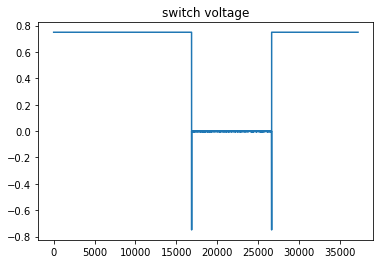

In [11]:
plot_raw_data("./data/yamashita/c_1.dat")

In [22]:
def extract_target(file_path):
    """extract pulse in the target range (between switches)
    """
    t = []
    y1 = [] #pkin
    y2 = [] #gkin
    base_t = "+0.74963" # 決め打ち
    with open(file_path, "r") as f:
        line = f.readline()
        line = f.readline()
        ls = line.split()
        assert ls[-1] == base_t
        while line:
            line = f.readline()
            ls = line.split()
            try:
                # 再びスイッチを押すまで計測
                if ls[-1] !=  base_t:
                    t.append(float(ls[0]))
                    y1.append(float(ls[1]))
                    y2.append(float(ls[2]))
            except Exception as e:
                continue
    assert len(t) == len(y1)
    y1 = np.array(y1)
    y2 = np.array(y2)
    return y1, y2

def convert_to_frequency(t_array):
    """Convert time series data into power spectrum
    """
    f_array = [np.sqrt(d.real**2+d.imag**2) for d in np.fft.fft(t_array)]
    return f_array

def sample_from_t_array(t_array, N=5000):
    """Keep the sample size constant so that we can keep the df constant as well.
         dt = 0.0002
         so if we set N=5000, T=Ndt = 1, then we can get df=1 (fs=5000 as well)
    """
    return t_array[-N:]
    
def plot(file_path):
    y1, y2 = extract_target(file_path)
    print(len(y1))
    y1 = sample_from_t_array(y1)
    y2 = sample_from_t_array(y2)
    amp1 = convert_to_frequency(y1)
    amp2 = convert_to_frequency(y2)
    plt.plot(amp1[:2500], color="blue", alpha=0.5, label="x_p")
    plt.plot(amp2[:2500], color="red", alpha=0.5, label="x_g")
    #plt.title("power spectrum")
    plt.xlabel("frequency [1/Hz]")
    plt.ylabel("power [W]")
    plt.legend()
    plt.ylim([0, 200])
    plt.show()

9801


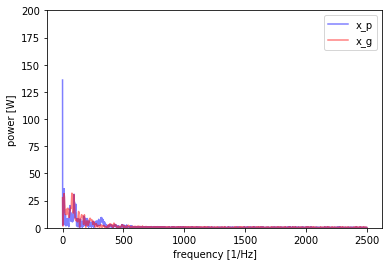

In [23]:
plot("./data/yamashita/c_1.dat")

## 2. ML

In [29]:
def extract_feature(file_path):
    Ns = 5000 # samples
    Nq = 2500 
    y1, y2 = extract_target(file_path)
    y1 = sample_from_t_array(y1, Ns)
    y2 = sample_from_t_array(y2, Ns)
    amp1 = convert_to_frequency(y1)
    amp2 = convert_to_frequency(y2)
    amp1 = amp1[:Nq]
    amp2 = amp2[:Nq]
    feature = np.concatenate((amp1, amp2))
    return feature

def make_dataset(data_path="./data/*/*.dat"):
    X = []
    y = []
    files_dir = glob.glob(data_path)
    #print("total files: ", len(files_dir))
    for file_path in files_dir:
        try:
            label = file_path.split("/")[-1].split("_")[0]
            feature = extract_feature(file_path)
            X.append(feature)
            y.append(label)
        except Exception as e:
            print(e)
            print(file_path)
    return X, y

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [30]:
def train_and_test(data_path, plot=True):
    # prepare data
    X, y = make_dataset(data_path)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
    #print("train: ", len(train_X))
    #print("test: ", len(test_X))
    
    # pca
    pca = PCA(n_components=10)
    pca_train_X = pca.fit_transform(train_X)
    pca_test_X = pca.transform(test_X)
    
    # model
    model = RandomForestClassifier(max_depth=30)
    model.fit(pca_train_X, train_y)
    
    # predict
    pred_y = model.predict(pca_test_X)
    
    # accuracy
    accuracy = np.sum([1 for p, t in zip(pred_y, test_y) if p==t])/len(pred_y)
    print("accuracy: ", accuracy)
    
    # confusion matrix
    if plot:
        cnf_matrix = confusion_matrix(test_y, pred_y)
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=["c", "g", "p"],
                                          normalize=True, title='Confusion matrix')
    
    return accuracy, model, pca


./data/kyo/c_29.dat
accuracy:  0.9
Normalized confusion matrix


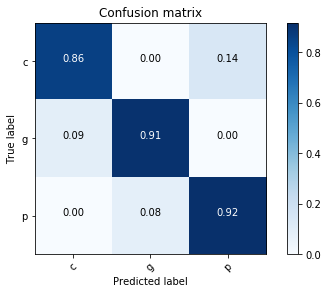


./data/nakanishi/p_1.dat
accuracy:  0.75
Normalized confusion matrix


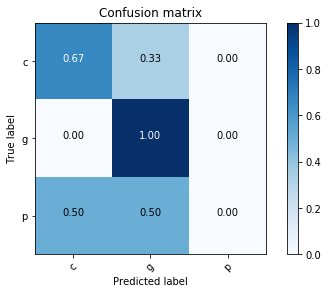

accuracy:  0.6
Normalized confusion matrix


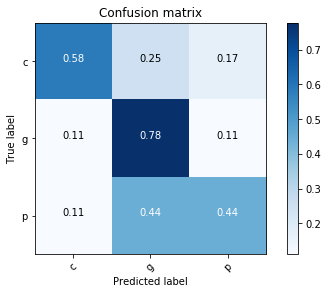


./data/kyo/c_29.dat

./data/nakanishi/p_1.dat
accuracy:  0.597222222222
Normalized confusion matrix


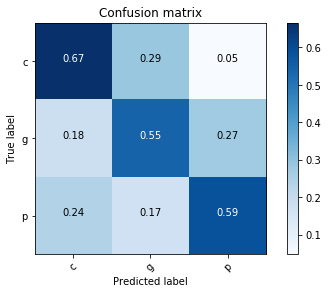

In [32]:
name_list = ["kyo", "nakanishi", "yamashita"]
for name in name_list:
    _, _, _ = train_and_test("./data/{0}/*.dat".format(name))
accu, model, pca = train_and_test("./data/*/*.dat".format(name))

## socket connection

start!
pred:  p


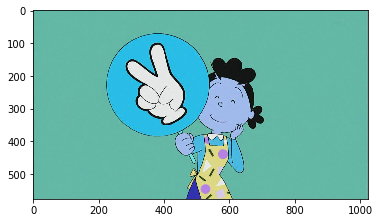

5.105515003204346
start!
pred:  p


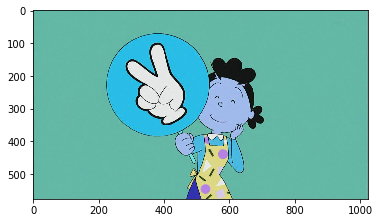

5.121272802352905
start!
pred:  p


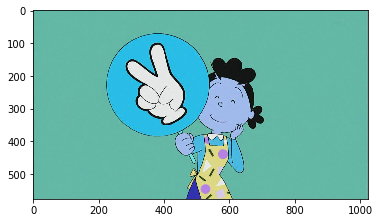

5.0888988971710205
start!
pred:  p


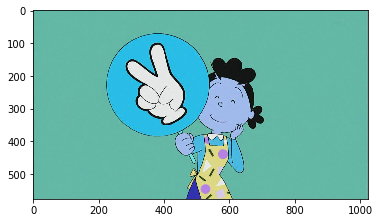

5.089332103729248
start!
pred:  p


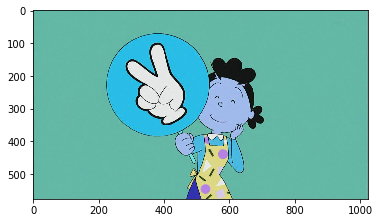

5.101808071136475
start!
pred:  g


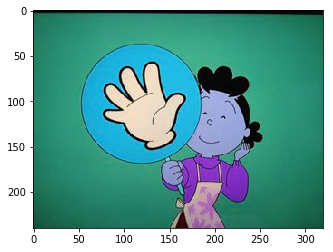

5.082779884338379
start!
pred:  p


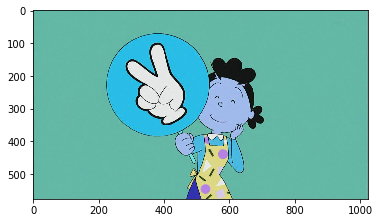

5.072548151016235
start!
pred:  p


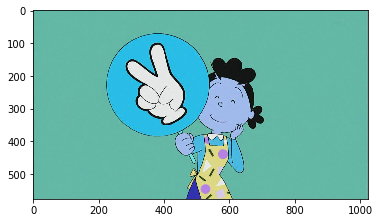

5.08531379699707
start!
pred:  p


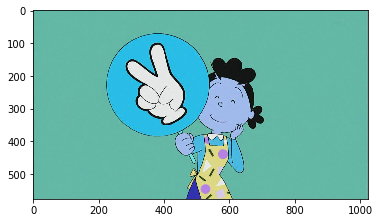

5.095543146133423
start!
pred:  g


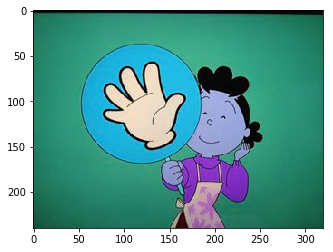

5.091411113739014
start!
pred:  p


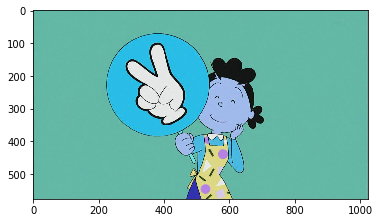

5.103921175003052
start!


KeyboardInterrupt: 

In [179]:
import cv2
import time
import socket
host = "157.82.201.135"
port = 50017
client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
client.connect((host, port))

for _ in range(20):
    print("start!")
    start = time.time()
    response_list = []
    while time.time() - start <= 4.8:
        response_list.extend(client.recv(int(1024)).decode("utf-8").split("\n")[1:-1])

    Ns = 5000 # samples
    Nq = 2500
    y1 = []
    y2 = []
    base_t = "+0.74963"
    for line in response_list:
        ls = line.split()
        try:
            if ls[-1] !=  base_t:
                y1.append(float(ls[1]))
                y2.append(float(ls[2]))
        except Exception as e:
            continue
    y1 = np.array(y1)
    y2 = np.array(y2)
    y1 = sample_from_t_array(y1, Ns)
    y2 = sample_from_t_array(y2, Ns)
    amp1 = convert_to_frequency(y1)
    amp2 = convert_to_frequency(y2)
    amp1 = amp1[:Nq]
    amp2 = amp2[:Nq]
    feature = np.concatenate((amp1, amp2))
    feature = pca.transform([feature])
    pred = model.predict(feature)[0]
    print("pred: ", pred)
    if pred == "g":
        plt.imshow(cv2.imread("./figures/p.jpg"))
    elif pred == "c":
        plt.imshow(cv2.imread("./figures/g.jpg"))
    else:
        plt.imshow(cv2.imread("./figures/c.jpg"))
    plt.show()
    print(time.time() - start)
client.close()